In [166]:
import pandas as pd
import numpy as np
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm

# Helper Functions

In [167]:
def uni_sort_value_weight(period_back, df_sort):
    '''
    perform univariate sort and form value weighted portfolios
    period_back: number of periods reserved  
    df_sort: sorting data
    return portfolio returns for all deciles and the winner minus loser portfolio
    '''
    timer = time.time() # reset our timer

    # create an empty dataframe. We will store our portfolios in here
    all_dec_portfolios = pd.DataFrame()

    # loop over all dates (months) in the data
    for datem in tqdm(ret.index[period_back:]):
        #print(datem)
    
        # take the companies that were alive at t-1
        permno_list = list((crsp.loc[crsp['datem']==datem-1,'PERMNO'].unique())) 
        # get the sorting variable for these companies at t-1
        # to choose another sorting variable (e.g. beta) simply switch variable at this point)
        sorting_data = df_sort.loc[datem-1,permno_list]
    
        # sort into 10 baskets
        ranks = pd.qcut(sorting_data,10,labels=False).reset_index()
        ranks.columns = ['PERMNO','rank']
    
        dec_port = pd.DataFrame()
        for portf in range(0,10):
            #print(portf)
        
            # get list of permnos that are in this portfolio
            basket = ranks.loc[ranks['rank'] == portf,'PERMNO'].tolist()
        
            # get returns of these permnos
            ret_port_stocks = ret.loc[datem,basket]
            
            
            # get the absolute values of stock prices at t-1
            # get the number of share outstanding for the stocks at t-1
            
            # we use absolute values because for stocks which don't have closing price data and when 
            # average bid and ask is used the price will be marked as negative
            stock_info = np.absolute(crsp.loc[crsp['datem']==datem-1].set_index('PERMNO').loc[basket, ['PRC', 'SHROUT']])
            
            # calculate market capitalizations of stocks
            market_cap = stock_info['PRC'] * stock_info['SHROUT']
            #print(market_cap)
            # portfolio weighted by market cap
            port_weights = market_cap / market_cap.sum()
            
            # find the return of the portfolio
            # use nansum since there are na values
            ret_port = np.nansum(port_weights*ret_port_stocks)
            ret_port = pd.DataFrame(ret_port,index=[datem],columns=[str(portf)])
            
            # collect results in dec_port
            dec_port = pd.concat([dec_port, ret_port], axis=1)
    
        # collect results in all_dec_portfolios
        all_dec_portfolios = pd.concat([all_dec_portfolios, dec_port])
    # calculate return when longing top winner decile and shorting bottom loser decile   
    all_dec_portfolios['9-0'] = all_dec_portfolios['9'] - all_dec_portfolios['0']
    return all_dec_portfolios
    #print('Step 3 completed in %.1fs' % (time.time()-timer)) # show how long it took to run this code block

In [168]:
def uni_sort_equal_weight(period_back, df_sort):
    timer = time.time() # reset our timer

    # create an empty dataframe. We will store our portfolios in here
    all_dec_portfolios = pd.DataFrame()

    # loop over all dates (months) in the data
    for datem in tqdm(ret.index[period_back:]):
        #print(datem)
    
        # take the companies that were alive at t-1
        permno_list = list((crsp.loc[crsp['datem']==datem-1,'PERMNO'].unique())) 
        #print(permno_list)
        # get the sorting variable for these companies at t-1
        # to choose another sorting variable (e.g. beta) simply switch variable at this point)
        sorting_data = df_sort.loc[datem-1,permno_list]
    
        # sort into 10 baskets
        ranks = pd.qcut(sorting_data,10,labels=False).reset_index()
        ranks.columns = ['PERMNO','rank']
    
        dec_port = pd.DataFrame()
        for portf in range(0,10):
            #print(portf)
        
            # get list of permnos that are in this portfolio
            basket = ranks.loc[ranks['rank'] == portf,'PERMNO'].tolist()
        
            # get returns of these permnos
            ret_port_stocks = ret.loc[datem,basket]
            #assert sum(np.isnan(ret_port_stocks))==0, 'there is na in ret_port_stocks'
            # find the return of the portfolio
            ret_port = ret_port_stocks.mean()
            #print(ret_port)
            ret_port = pd.DataFrame(ret_port,index=[datem],columns=[str(portf)])
            
            # collect results in dec_port
            dec_port = pd.concat([dec_port, ret_port], axis=1)
    
        # collect results in all_dec_portfolios
        all_dec_portfolios = pd.concat([all_dec_portfolios, dec_port])
    all_dec_portfolios['9-0'] = all_dec_portfolios['9'] - all_dec_portfolios['0']
    return all_dec_portfolios
    #print('Step 3 completed in %.1fs' % (time.time()-timer)) # show how long it took to run this code block

In [169]:
def merge_with_FF(all_dec_portfolios):
    '''
    merge the all_dec_portfolios dataframe with Fama French 3 factor data
    '''
    ## load and prepare fama french data
    # load Fama French monthly factors
    ff = pd.read_csv(direct+'F-F_Research_Data_Factors_2018.csv')

    # date variables
    ff['year']=[int(str(i)[0:4]) for i in ff['DATE']]
    ff['month']=[int(str(i)[4:6]) for i in ff['DATE']]
    ff.set_index('DATE',inplace=True)

    # formatting
    ff.columns = ['ExMkt', 'SMB', 'HML', 'RF','year','month']  # Rename the columns
    ff[['ExMkt', 'SMB', 'HML', 'RF']] = ff[['ExMkt', 'SMB', 'HML', 'RF']]/100 # FF data is in percent. Convert to simple returns
    #ff = ff[['ExMkt', 'SMB', 'HML', 'RF','year','month']]


    ## merge portfolio returns with Fama French data
    # date variables
    adp = all_dec_portfolios.copy()
    adp['year']=adp.index.year
    adp['month']=adp.index.month

    # merge
    adp = adp.merge(ff, on=['year','month'])
    # Calculate the excess returns
    port_names = [f'{i}' for i in reversed(range(10))]
    for decile in port_names:
        adp['ExRet_'+decile] = adp[decile]-adp['RF']
    return adp

def summary_stats(adp):
    summary = adp.groupby('year').agg(cum_ret=pd.NamedAgg('ExRet_9-0', lambda x: np.sum(np.log(x+1))),
                        average_return=pd.NamedAgg('ExRet_9-0', 'mean'),
                        volatility=pd.NamedAgg('ExRet_9-0','std'),
                        sharpe=pd.NamedAgg('ExRet_9-0',Sharpe_Ratio))
    summary['max_drawdown'] = ((np.exp(summary['cum_ret'])-1) / (np.exp(summary['cum_ret'])-1).cummax()) - 1
    summary['cum_ret'] = np.exp(summary['cum_ret'].cumsum())-1

In [170]:
def Sharpe_Ratio(excess_returns):
    '''
    Calculate Sharpe Ratio for individual asset
    '''
    return excess_returns.mean() / excess_returns.std()

def summary_stats(adp):
    summary = adp.groupby('year').agg(cum_ret=pd.NamedAgg('9-0', lambda x: np.sum(np.log(x+1))),
                        average_return=pd.NamedAgg('9-0', 'mean'),
                        volatility=pd.NamedAgg('9-0','std'),
                        sharpe=pd.NamedAgg('9-0',Sharpe_Ratio))
    summary['cum_ret'] = np.exp(summary['cum_ret'].cumsum())-1
    summary['max_drawdown'] = (summary['cum_ret'] / summary['cum_ret'].cummax())-1
    return summary

def FF3f_regression(adp):
    table_ff = pd.DataFrame()
    port_names = [f'ExRet_{i}' for i in reversed(range(10))] + ['9-0']
    for decile in port_names:
        t1FF = pd.DataFrame()
    
        # regress portfolio excess return on Fama French factors
        resultsFF = sm.OLS(adp[decile],sm.add_constant(adp[['ExMkt','SMB','HML']])).fit()
    
        # store regression results in table
        t1FF['alpha']=[resultsFF.params[0]]
        t1FF['beta_mkt']=[resultsFF.params[1]]
        t1FF['beta_size']=[resultsFF.params[2]]
        t1FF['beta_hml']=[resultsFF.params[3]]
        t1FF['alpha_t'] = [resultsFF.tvalues[0]]
        t1FF['rmse']=[np.sqrt(resultsFF.mse_resid)]
        t1FF['decile']=decile
        t1FF['R2']=[resultsFF.rsquared]
        table_ff = pd.concat([table_ff,t1FF])

    table_ff.set_index('decile',inplace=True)
    return table_ff

# Step 1: Preparing the CRSP file

In [171]:
direct = 'PortStrat2020/'
timer = time.time() # record the current time, so we can measure how long the code takes to run

# load data
crsp = pd.read_csv(direct+'CRSP_Monthly_2018.csv')

## formatting
# You should see that one of the important variables 'RET' (return) is not a number but 'object'.
# It is preferable to have this variable as a number, which Python denotes as float64 (float64 is just a special way of saying that a variable is a number)
# If you are interested search for 'floating point number'on internet. But it is computer-science issue!

# Changes the returns to number format
crsp['RET'] = pd.to_numeric(crsp['RET'],errors='coerce') 

# Change the dateformat
crsp['date'] = pd.to_datetime(crsp['date'], format='%Y%m%d')

# create monthly date variable
crsp['datem'] = crsp['date'].dt.to_period('M')

## Some basic data cleaning
# keep only common shares
crsp = crsp[(crsp.SHRCD==10) | (crsp.SHRCD==11)] 

# keep only stocks from NYSE, AMEX and NASDAQ
crsp = crsp[(crsp.EXCHCD==1) | (crsp.EXCHCD==2) | (crsp.EXCHCD==3)] 

# excludes prices below $1
#crsp = crsp[crsp.PRC >= 1]

# make sure that there are no duplicates
crsp = crsp.drop_duplicates(subset=['date','PERMNO'])

# get crsp returns in "wide" format (i.e. "pivot" the crsp data set)
ret = crsp.pivot(index='datem',columns='PERMNO',values='RET')

print('Step 1 completed in %.1fs' % (time.time()-timer)) # show how long it took to run this code block

Step 1 completed in 14.0s


# Step 2: a) Load the Residual Momentum data

In [172]:
rmom12_2 = pd.read_csv('rmom12_2_1980_2017.csv', index_col=0)
rmom12_2.index = pd.to_datetime(rmom12_2.index, format='%Y-%m')
rmom12_2.index = rmom12_2.index.to_period('M')
rmom12_2.columns = rmom12_2.columns.astype(int)
#romo12_2

# Step 2: b) Calculate Total Return Momentums

In [173]:
timer = time.time() # record the current time, so we can measure how long the code takes to run

# calculate momentum score (cumulative return over the past 12 months)
lret = np.log(1+ret)

mom12 = lret.rolling(window=12,min_periods=12).sum() # momentum over the last 12 months
mom12_2 = np.exp(lret.rolling(window=12,min_periods=12).sum() - lret) - 1 # momentum over the last 12 months, minus the last month

# delete variables that we do no longer use
del lret
#mom12_2

# Step 3: Sort and Form Portfolios

## Sort on total return momentum (equal weighted)

In [174]:
adp_mom_ew = merge_with_FF(uni_sort_equal_weight(period_back=12, df_sort=mom12_2))
adp_mom_ew.head()

100%|██████████| 444/444 [00:23<00:00, 18.93it/s]


,0,1,2,3,4,5,6,7,8,9,...,ExRet_9,ExRet_8,ExRet_7,ExRet_6,ExRet_5,ExRet_4,ExRet_3,ExRet_2,ExRet_1,ExRet_0
0,0.039207,0.027089,0.031930,0.031708,0.021585,0.005498,-0.001365,-0.015033,-0.035256,-0.045432,...,-0.055832,-0.045656,-0.025433,-0.011765,-0.004902,0.011185,0.021308,0.021530,0.016689,0.028807
1,-0.001611,0.018777,0.010829,0.010901,0.013167,0.016147,0.008814,0.007025,0.003554,-0.017493,...,-0.028193,-0.007146,-0.003675,-0.001886,0.005447,0.002467,0.000201,0.000129,0.008077,-0.012311
2,0.074784,0.070206,0.080340,0.081958,0.071625,0.073568,0.068692,0.069468,0.087384,0.079810,...,0.067710,0.075284,0.057368,0.056592,0.061468,0.059525,0.069858,0.068240,0.058106,0.062684
3,0.034787,0.023962,0.021792,0.028201,0.030430,0.026145,0.029602,0.031162,0.036079,0.032643,...,0.021843,0.025279,0.020362,0.018802,0.015345,0.019630,0.017401,0.010992,0.013162,0.023987
4,0.009396,0.009867,0.016402,0.013623,0.028057,0.027533,0.028543,0.022007,0.056317,0.055828,...,0.044328,0.044817,0.010507,0.017043,0.016033,0.016557,0.002123,0.004902,-0.001633,-0.002104


## Sort on residual return momentum (equal weighted)

In [175]:
adp_rmom_ew = merge_with_FF(uni_sort_equal_weight(period_back=36, df_sort=rmom12_2))
adp_rmom_ew.head()

100%|██████████| 420/420 [00:22<00:00, 18.96it/s]


,0,1,2,3,4,5,6,7,8,9,...,ExRet_9,ExRet_8,ExRet_7,ExRet_6,ExRet_5,ExRet_4,ExRet_3,ExRet_2,ExRet_1,ExRet_0
0,0.121333,0.098098,0.101467,0.086683,0.097547,0.075414,0.092575,0.097014,0.072681,0.070400,...,0.063500,0.065781,0.090114,0.085675,0.068514,0.090647,0.079783,0.094567,0.091198,0.114433
1,0.026822,0.043929,0.038742,0.054820,0.058082,0.062534,0.056543,0.072451,0.085262,0.067696,...,0.061496,0.079062,0.066251,0.050343,0.056334,0.051882,0.048620,0.032542,0.037729,0.020622
2,0.043476,0.049016,0.052208,0.045554,0.047338,0.048163,0.055453,0.059431,0.057113,0.069685,...,0.063385,0.050813,0.053131,0.049153,0.041863,0.041038,0.039254,0.045908,0.042716,0.037176
3,0.055880,0.072697,0.068678,0.064248,0.089665,0.073490,0.089056,0.091379,0.085757,0.089707,...,0.082607,0.078657,0.084279,0.081956,0.066390,0.082565,0.057148,0.061578,0.065597,0.048780
4,0.097881,0.077554,0.080093,0.065842,0.082884,0.077016,0.075477,0.099934,0.080721,0.079045,...,0.072145,0.073821,0.093034,0.068577,0.070116,0.075984,0.058942,0.073193,0.070654,0.090981


## Sort on total return momentum (value weighted)

In [176]:
adp_mom_vw = merge_with_FF(uni_sort_value_weight(period_back=12, df_sort=mom12_2))
adp_mom_vw.head()

100%|██████████| 444/444 [01:36<00:00,  4.58it/s]


,0,1,2,3,4,5,6,7,8,9,...,ExRet_9,ExRet_8,ExRet_7,ExRet_6,ExRet_5,ExRet_4,ExRet_3,ExRet_2,ExRet_1,ExRet_0
0,-0.008272,0.001478,0.029897,-0.001808,-0.017372,-0.023796,-0.034115,-0.061771,-0.095532,-0.119593,...,-0.129993,-0.105932,-0.072171,-0.044515,-0.034196,-0.027772,-0.012208,0.019497,-0.008922,-0.018672
1,-0.007982,0.034840,0.032577,0.011217,0.025129,0.030567,0.031363,0.000641,0.024020,-0.001877,...,-0.012577,0.013320,-0.010059,0.020663,0.019867,0.014429,0.000517,0.021877,0.024140,-0.018682
2,0.142648,0.085653,0.044927,0.033176,0.048640,0.023139,0.034129,0.043328,0.060103,0.088050,...,0.075950,0.048003,0.031228,0.022029,0.011039,0.036540,0.021076,0.032827,0.073553,0.130548
3,-0.009582,-0.009475,0.024351,-0.015978,-0.011608,-0.019340,-0.026032,-0.021164,-0.003092,-0.003314,...,-0.014114,-0.013892,-0.031964,-0.036832,-0.030140,-0.022408,-0.026778,0.013551,-0.020275,-0.020382
4,-0.006524,0.029763,-0.010295,0.004590,0.017558,0.002489,0.002815,0.019467,0.037103,0.062825,...,0.051325,0.025603,0.007967,-0.008685,-0.009011,0.006058,-0.006910,-0.021795,0.018263,-0.018024


## Sort on residual return momentum (value weighted)

In [177]:
adp_rmom_vw = merge_with_FF(uni_sort_value_weight(period_back=36, df_sort=rmom12_2))
adp_rmom_vw.head()

100%|██████████| 420/420 [01:32<00:00,  4.56it/s]


,0,1,2,3,4,5,6,7,8,9,...,ExRet_9,ExRet_8,ExRet_7,ExRet_6,ExRet_5,ExRet_4,ExRet_3,ExRet_2,ExRet_1,ExRet_0
0,0.031149,0.042007,0.036880,0.094373,0.035618,0.032777,0.025665,0.035990,0.024685,0.027347,...,0.020447,0.017785,0.029090,0.018765,0.025877,0.028718,0.087473,0.029980,0.035107,0.024249
1,0.016651,-0.002963,0.018195,0.043897,0.022558,0.050866,0.041226,0.043544,0.051184,0.037114,...,0.030914,0.044984,0.037344,0.035026,0.044666,0.016358,0.037697,0.011995,-0.009163,0.010451
2,0.023613,0.032006,0.038408,0.043711,0.043668,0.034277,0.053002,0.022528,0.030103,0.027362,...,0.021062,0.023803,0.016228,0.046702,0.027977,0.037368,0.037411,0.032108,0.025706,0.017313
3,0.059429,0.082564,0.057534,0.062310,0.071666,0.056225,0.069035,0.074773,0.064212,0.102664,...,0.095564,0.057112,0.067673,0.061935,0.049125,0.064566,0.055210,0.050434,0.075464,0.052329
4,0.040426,0.029666,0.014079,-0.000820,0.024478,0.004616,0.000763,-0.000451,-0.002130,-0.009640,...,-0.016540,-0.009030,-0.007351,-0.006137,-0.002284,0.017578,-0.007720,0.007179,0.022766,0.033526


# Step 4: Total Return Momentum vs. Residual Return Momentum 

In [178]:
sum_stats_mom_ew = summary_stats(adp_mom_ew)
sum_stats_rmom_ew = summary_stats(adp_rmom_ew)

sum_stats_mom_vw = summary_stats(adp_mom_vw)
sum_stats_rmom_vw = summary_stats(adp_rmom_vw)

## Monthly Cumulative Returns

In [187]:
# set month as index
adp_mom_ew_cpy = adp_mom_ew.set_index(rmom12_2.index[12:])
adp_rmom_ew_cpy = adp_rmom_ew.set_index(rmom12_2.index[36:])

adp_mom_vw_cpy = adp_mom_vw.set_index(rmom12_2.index[12:])
adp_rmom_vw_cpy = adp_rmom_vw.set_index(rmom12_2.index[36:])

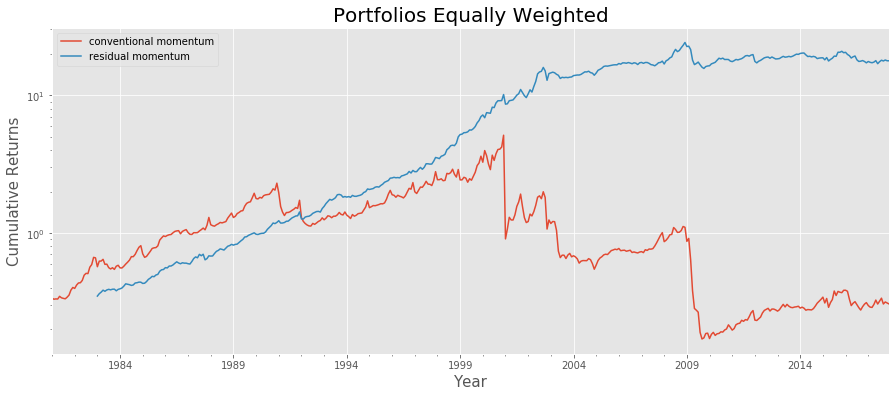

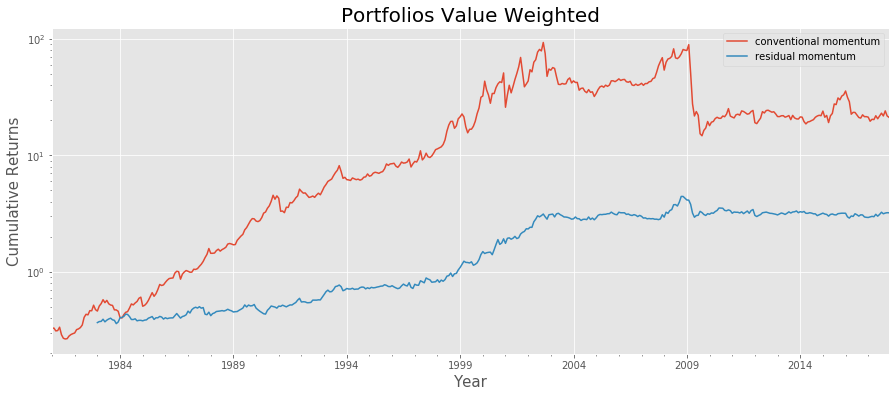

In [190]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set_title('Portfolios Equally Weighted', fontdict={'fontsize':20})
ax.set_ylabel('Cumulative Returns', fontdict={'fontsize':15})
(np.exp((np.log(adp_mom_ew_cpy['9-0']+1).cumsum())-1)).plot(logy=True, ax=ax)
(np.exp((np.log(adp_rmom_ew_cpy['9-0']+1).cumsum())-1)).plot(logy=True, ax=ax)
ax.set_xlabel('Year', fontdict={'fontsize':15})

ax.legend(['conventional momentum', 'residual momentum'])

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set_title('Portfolios Value Weighted', fontdict={'fontsize':20})
ax.set_ylabel('Cumulative Returns', fontdict={'fontsize':15})
(np.exp((np.log(adp_mom_vw_cpy['9-0']+1).cumsum())-1)).plot(logy=True, ax=ax)
(np.exp((np.log(adp_rmom_vw_cpy['9-0']+1).cumsum())-1)).plot(logy=True, ax=ax)
ax.set_xlabel('Year', fontdict={'fontsize':15})

ax.legend(['conventional momentum', 'residual momentum'])

## Volatility

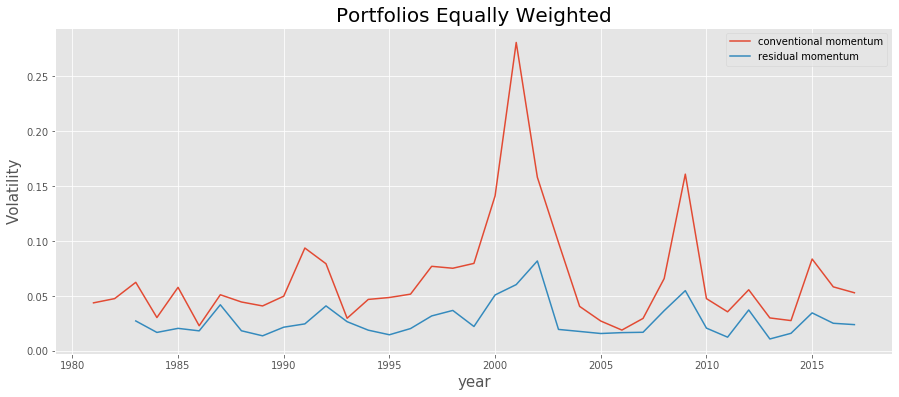

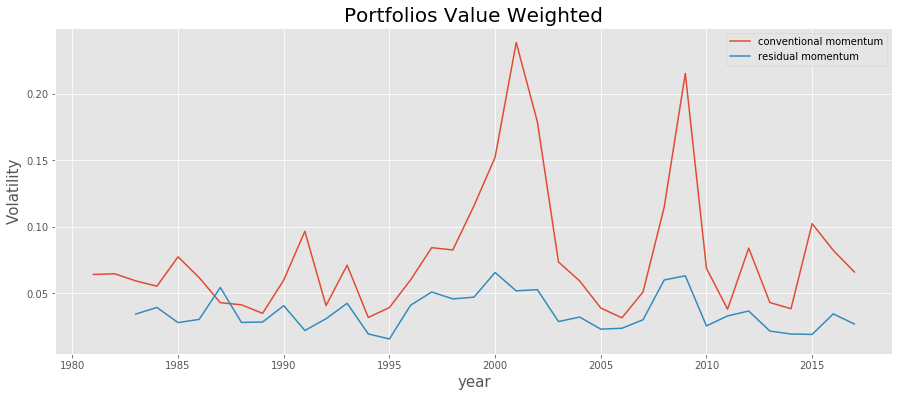

In [195]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set_title('Portfolios Equally Weighted', fontdict={'fontsize':20})
ax.set_xlabel('Year', fontdict={'fontsize':15})
ax.set_ylabel('Volatility', fontdict={'fontsize':15})
sum_stats_mom_ew['volatility'].plot(ax=ax)
sum_stats_rmom_ew['volatility'].plot(ax=ax)
ax.legend(['conventional momentum', 'residual momentum'])

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set_title('Portfolios Value Weighted', fontdict={'fontsize':20})
ax.set_xlabel('Year', fontdict={'fontsize':15})
ax.set_ylabel('Volatility', fontdict={'fontsize':15})
sum_stats_mom_vw['volatility'].plot(ax=ax)
sum_stats_rmom_vw['volatility'].plot(ax=ax)
ax.legend(['conventional momentum', 'residual momentum'])

## Sharpe Ratio

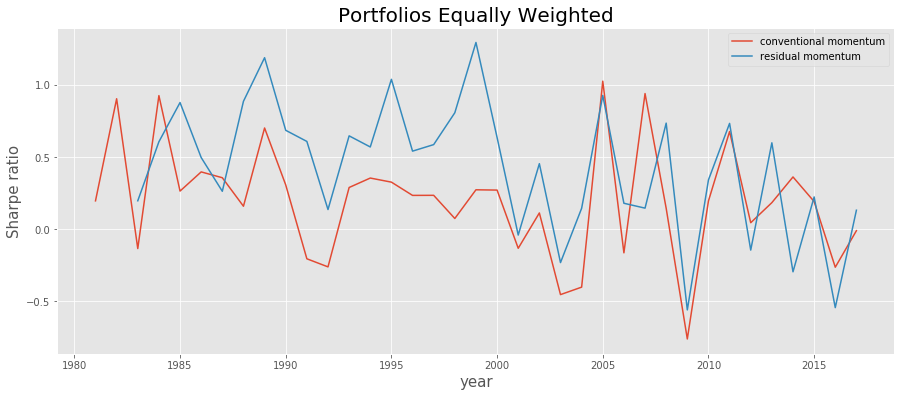

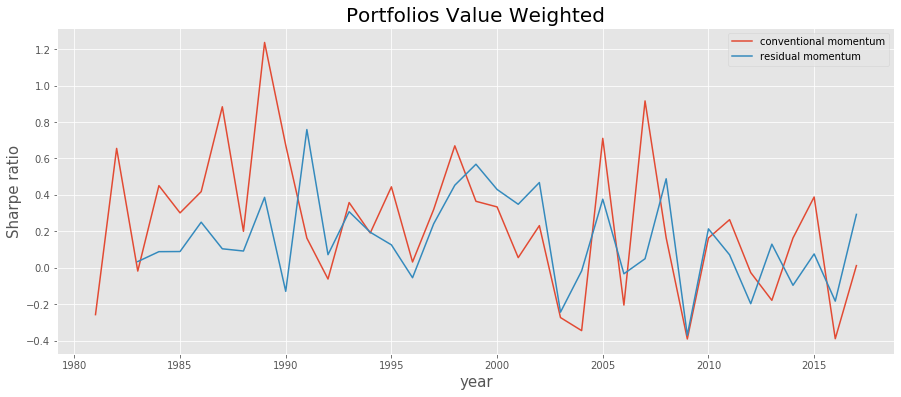

In [196]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set_title('Portfolios Equally Weighted', fontdict={'fontsize':20})
ax.set_xlabel('Year', fontdict={'fontsize':15})
ax.set_ylabel('Sharpe ratio', fontdict={'fontsize':15})
sum_stats_mom_ew['sharpe'].plot(ax=ax)
sum_stats_rmom_ew['sharpe'].plot(ax=ax)
ax.legend(['conventional momentum', 'residual momentum'])

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set_title('Portfolios Value Weighted', fontdict={'fontsize':20})
ax.set_xlabel('Year', fontdict={'fontsize':15})
ax.set_ylabel('Sharpe ratio', fontdict={'fontsize':15})
sum_stats_mom_vw['sharpe'].plot(ax=ax)
sum_stats_rmom_vw['sharpe'].plot(ax=ax)
ax.legend(['conventional momentum', 'residual momentum'])

## Maximum Drawdown

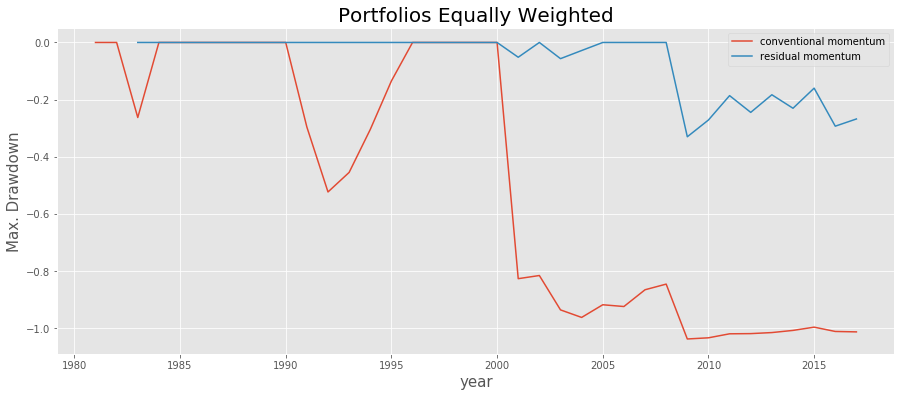

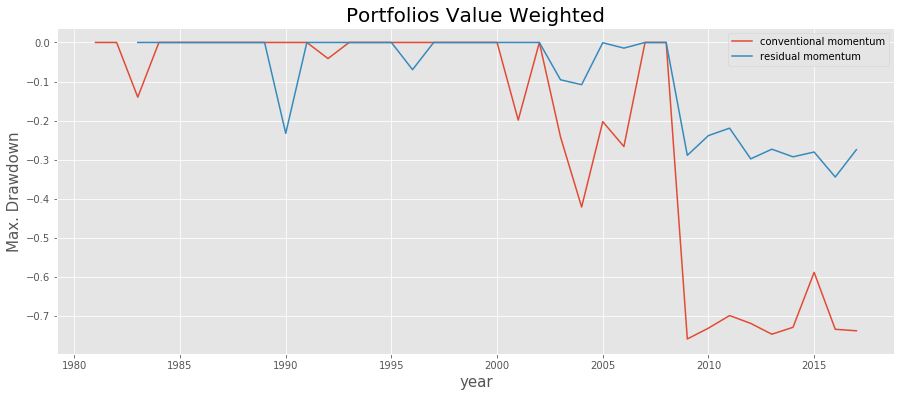

In [197]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set_title('Portfolios Equally Weighted', fontdict={'fontsize':20})
ax.set_xlabel('Year', fontdict={'fontsize':15})
ax.set_ylabel('Max. Drawdown', fontdict={'fontsize':15})
sum_stats_mom_ew['max_drawdown'].plot(ax=ax)
sum_stats_rmom_ew['max_drawdown'].plot(ax=ax)
ax.legend(['conventional momentum', 'residual momentum'])

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set_title('Portfolios Value Weighted', fontdict={'fontsize':20})
ax.set_xlabel('Year', fontdict={'fontsize':15})
ax.set_ylabel('Max. Drawdown', fontdict={'fontsize':15})
sum_stats_mom_vw['max_drawdown'].plot(ax=ax)
sum_stats_rmom_vw['max_drawdown'].plot(ax=ax)
ax.legend(['conventional momentum', 'residual momentum'])

# Step 5: Regression Analysis

In [191]:
FF3f_regression(adp_mom_ew)

,alpha,beta_mkt,beta_size,beta_hml,alpha_t,rmse,R2
decile,,,,,,,
ExRet_9,0.004700,1.046507,1.142136,-0.127414,3.732146,0.025901,0.859832
ExRet_8,0.004265,0.894842,0.823644,0.108903,5.293108,0.016571,0.899424
ExRet_7,0.003725,0.851930,0.651694,0.216384,5.846984,0.013102,0.918212
ExRet_6,0.002857,0.848639,0.598810,0.294124,4.858615,0.012092,0.924972
ExRet_5,0.001479,0.879572,0.538474,0.340031,2.341119,0.012995,0.914707
ExRet_4,0.000241,0.890901,0.590299,0.352289,0.322356,0.015360,0.890400
ExRet_3,-0.000804,0.966554,0.645598,0.361600,-0.812647,0.020356,0.845693
ExRet_2,-0.003126,1.066998,0.774112,0.364725,-2.247840,0.028607,0.779346
ExRet_1,-0.005171,1.142796,0.969052,0.317757,-2.536138,0.041933,0.675081


In [192]:
FF3f_regression(adp_rmom_ew)

,alpha,beta_mkt,beta_size,beta_hml,alpha_t,rmse,R2
decile,,,,,,,
ExRet_9,0.006494,0.957507,0.702040,0.217890,7.358670,0.017690,0.884980
ExRet_8,0.004939,0.943245,0.749045,0.276327,5.690672,0.017396,0.888296
ExRet_7,0.003850,0.928004,0.774592,0.308685,4.563096,0.016913,0.892754
ExRet_6,0.003282,0.950887,0.783154,0.300820,3.706987,0.017748,0.887583
ExRet_5,0.002136,0.955497,0.789758,0.364468,2.337396,0.018319,0.881316
ExRet_4,0.001203,0.974401,0.761204,0.356666,1.318807,0.018287,0.882670
ExRet_3,-0.000091,0.975140,0.768400,0.335989,-0.093202,0.019626,0.868289
ExRet_2,-0.001585,0.989821,0.769125,0.342433,-1.518312,0.020930,0.855616
ExRet_1,-0.002226,1.051409,0.780659,0.295255,-1.807293,0.024689,0.825849


In [193]:
FF3f_regression(adp_mom_vw)

,alpha,beta_mkt,beta_size,beta_hml,alpha_t,rmse,R2
decile,,,,,,,
ExRet_9,0.004438,1.050809,0.564598,-0.409984,2.771682,0.032936,0.751599
ExRet_8,0.001127,0.937446,0.106058,-0.112358,1.091081,0.021243,0.802828
ExRet_7,0.001512,0.931146,-0.093007,0.058518,1.917819,0.016216,0.857979
ExRet_6,0.000380,0.921142,-0.104009,0.135151,0.533916,0.014651,0.876137
ExRet_5,-0.001194,0.955102,-0.105506,0.181454,-1.639678,0.014976,0.878325
ExRet_4,-0.000999,1.026676,-0.073638,0.193673,-1.063640,0.019311,0.834718
ExRet_3,-0.001304,1.087615,-0.019101,0.259869,-1.049853,0.025551,0.764462
ExRet_2,-0.005699,1.221827,0.124644,0.305443,-3.419567,0.034278,0.701435
ExRet_1,-0.010020,1.418994,0.306056,0.292653,-4.407198,0.046760,0.642165


In [194]:
FF3f_regression(adp_rmom_vw)

,alpha,beta_mkt,beta_size,beta_hml,alpha_t,rmse,R2
decile,,,,,,,
ExRet_9,0.002968,0.968789,-0.060960,-0.040297,2.910620,0.020438,0.808380
ExRet_8,0.002337,0.941871,-0.001540,0.013923,3.051982,0.015346,0.875945
ExRet_7,0.000202,0.955080,-0.032131,0.125075,0.269137,0.015041,0.879101
ExRet_6,0.001037,0.961435,-0.058927,0.030939,1.375592,0.015110,0.881381
ExRet_5,0.000617,0.970401,0.003096,0.075678,0.899760,0.013737,0.901964
ExRet_4,-0.000260,1.019656,-0.027089,0.085368,-0.349609,0.014931,0.894918
ExRet_3,-0.000884,1.024416,-0.085363,0.163988,-1.127285,0.015726,0.882769
ExRet_2,-0.000816,1.008159,-0.050064,0.081454,-0.988972,0.016537,0.871003
ExRet_1,-0.001902,1.061832,-0.022949,0.055980,-1.956358,0.019483,0.845561
